The goal of the following notebook is giving a brief introduction on the **Elastic Anonymization** algorithm fatures and usage. Briefly speaking, the algorithm works in six steps:
1. Using a fine-tuned BERT to perform named entity recognition on sensitive information found in the corpus.
2. The entities are, then, insterted back in the original corpus, as recognized by BERT.
3. A Fast Text model is trained on the new corpus.
4. For each new entity that needs to be anonymized, a similarity space is built as follows: the semantic and syntactic similarity between the entities and the other ones found in the corpus are computed and an anonymization region is defined in that space (for example, the square defined by $x=(.75, 1); y=(.75, 1)$).
5. A DBSCAN algorithm is used to spot all the entities belonging to the anonymization region.
6. All the spotted entities are anonymized using the same faking strategy.

The entities and their respective fakings are then stored inside a dictionary which represents the mapping 1 on 1. Since similar entities will have the same faking, the keys will be unique, but the values won't.

In [1]:
import textwrap

from IPython.display import display, Markdown
from transformers import pipeline

from anonymizer.config.config import Config
from anonymizer.preprocess.doc_processing import process
from anonymizer.utils import (
    create_documents_with_metadata, 
    visualize_ner_on_chunk
)
from anonymizer.elastic.eanon import ElasticAnonymizer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

c:\Users\Tobia\python-projects\elastic-anonymizer\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Tobia\python-projects\elastic-anonymizer\.venv\lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# the anonymize method from the ElasticAnonymizer class takes a list of langchain's Documents
docs_ = process(Config.DOCS_PATH / "example").fillna("")
docs = create_documents_with_metadata(docs_)
# chunking is required from the BERT model to work properly (the inference breaks for long texts).
chunker = SentenceTransformersTokenTextSplitter(chunk_overlap=50, tokens_per_chunk=250)
# limit to only 200 chunks
chunks = chunker.split_documents(docs)[:200]

In [6]:
SAVE_DOCS = False
# this could take a while to execute. Also, a little bit of tuning of the Fast Text 
# parameters could be required
anon = ElasticAnonymizer(use_pretrained_anon_state=False, faking_locale="en_US")
anon_docs = anon.anonymize(chunks, show_ner=False, epochs=100)

if SAVE_DOCS:
    ElasticAnonymizer.export_anon_df(anon_docs)

In [8]:
SAVE_ASSETS = False

if SAVE_ASSETS:
    anon.export_trained_embedder()
    anon.export_anon_state()

The central part of the elastic anonymization algorithm is building the similarity space for each entity. This space is defined by the **semantic** and **syntactic** similarity between an entity and all the other ones, recognized in the full corpus of selected documents. The two similarity measures are defined as follows:
- **semantic**: the cosine similarity between the embedded entities, with the embeddings computed by a Fast Text model, trained on the entire corpus.
- **syntactic**: the Jaro similarity between the entities.

The main idea is that all the entities belonging to the "anonymization region" of the similarity space will be anonymized using the same fake entity.

Anonymization for 'malta':  Rodriguez, Figueroa and Sanchez  
Anonymization for '. malta':  Rodriguez, Figueroa and Sanchez 


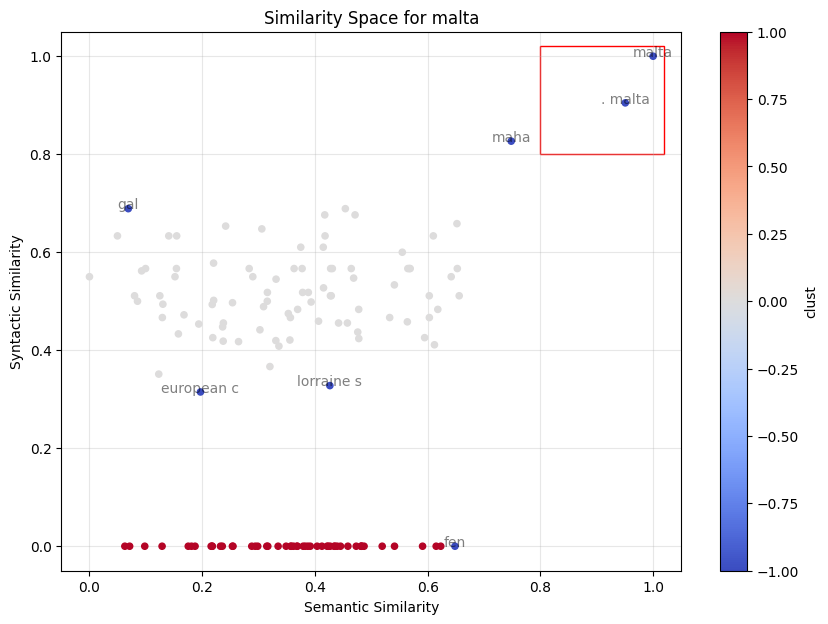

In [11]:
# plot the similarity space for the entity "mooney"
anon.plot_anonimization_space(
    "malta", 
    add_labels=True, 
    add_anonymization_region=True, 
    anon_region_x=(.80, 1.02),
    anon_region_y=(.80, 1.02)
)

print(
    f"Anonymization for 'malta': {anon.anon_state['malta']}", 
    f"\nAnonymization for '. malta': {anon.anon_state['. malta']}"
)

In [7]:
ner_pipeline = pipeline("ner", model=Config.ENG_NER_MODEL, aggregation_strategy="simple")
visualize_ner_on_chunk(chunks[0], ner_pipeline)

In [8]:
print("Anonymized Text:")
wrap_ = textwrap.fill(anon_docs["text"][0], width=120)
display(Markdown(f"```\n{wrap_}\n```")) 

Anonymized Text:


```
j. b. and others v.  Rodriguez, Figueroa and Sanchez  judgment j. b. and others v.  Rodriguez, Figueroa and Sanchez
judgment j. b. and others v.  Rodriguez, Figueroa and Sanchez  judgment second section case of j. b. and others v.
Rodriguez, Figueroa and Sanchez  ( application no. 1766 / 23 ) judgment art 3 ( substantive ) • conditions of detention
in immigration centres of the first applicant, not considered a presumed minor, not sufficient to reach required art 3
threshold • cumulative conditions of detention of the remaining applicants, presumed minors, amounting to inhuman and
degrading treatment art 13 ( + art 3 ) • effective remedy • constitutional redress proceedings ineffective for
complaints of ongoing detention conditions art 5 § 1 • deprivation of liberty • art 5 § 1 ( f ) • prevent unauthorised
entry into country • applicants ’ initial immigration detention unlawful • subsequent immigration detention of first
applicant, ultimately found to be an adult, in compliance with art 5 § 1 • subsequent detention of remaining applicants,
to allow processing of asylum claim with required prior age assessment, arbitrary art 5 § 4 •  Doyle Ltd  (  Mcclain,
Miller and Henderson b ) not an effective remedy for the review of the lawfulness of detention • decisions not subject
to subsequent control by a judicial body with “ full jurisdiction ” • lack of proper, clear and transparent
```

In [9]:
print("Denonymized Text:")
wrap = textwrap.fill(anon.deanonymize([anon_docs["text"][0]])[0], width=120)
display(Markdown(f"```\n{wrap}\n```")) 

Denonymized Text:


```
j. b. and others v. malta judgment j. b. and others v. malta judgment j. b. and others v. malta judgment second section
case of j. b. and others v. malta ( application no. 1766 / 23 ) judgment art 3 ( substantive ) • conditions of detention
in immigration centres of the first applicant, not considered a presumed minor, not sufficient to reach required art 3
threshold • cumulative conditions of detention of the remaining applicants, presumed minors, amounting to inhuman and
degrading treatment art 13 ( + art 3 ) • effective remedy • constitutional redress proceedings ineffective for
complaints of ongoing detention conditions art 5 § 1 • deprivation of liberty • art 5 § 1 ( f ) • prevent unauthorised
entry into country • applicants ’ initial immigration detention unlawful • subsequent immigration detention of first
applicant, ultimately found to be an adult, in compliance with art 5 § 1 • subsequent detention of remaining applicants,
to allow processing of asylum claim with required prior age assessment, arbitrary art 5 § 4 • immigration appeals board
( ia b ) not an effective remedy for the review of the lawfulness of detention • decisions not subject to subsequent
control by a judicial body with “ full jurisdiction ” • lack of proper, clear and transparent
```

There are a lot of improvement possibilities here: the de-anonymization step is just a reverse mapping from the values to the keys of the anonymization state (the dictionary storing the entities and their corresponding fake), and they're recognized from the text using regular expressions. Smarter ways of doing that are surely available.

Another improvement possibility concerns the inference time. In this example, we have relatively long documents (the European court resolutions), with 3 documents and 200 chunks (arbitrarily limited). Still, the inference time was significant: about 3 minutes including the training of the Fast Text model, which is usually very fast. A first step of improvement could be running the inference on the GPU. This should significantly reduce the inference time.